In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import h5py

In [2]:
WIN_SIZE = 80

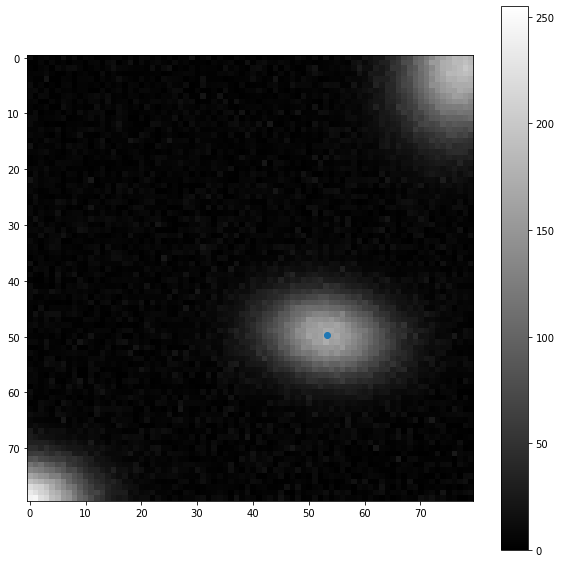

In [3]:
class DotSamplesGenerator:
    def __init__( self, win_size=80, dot_max_size=40, mu_range=30, noise_sigma_max=10.0 ):
        self.win_size = int(win_size)
        self.dot_max_size = dot_max_size
        self.mu_range = mu_range
        self.noise_sigma_max = noise_sigma_max
        
        xx,yy = np.meshgrid( np.arange(-self.win_size//2,self.win_size//2), np.arange(-self.win_size//2,self.win_size//2) )
        self.spts = np.vstack( (xx.flatten(), yy.flatten() ) )
        
    def _sample_helper( self, center ):
        # Random rotation angle:
        alpha = np.random.rand()*np.pi
        R = np.array( [[np.cos(alpha), -np.sin(alpha)],[np.sin(alpha),np.cos(alpha)]], dtype=np.float )

        # Generate semi-axes lengths
        size = (np.random.rand(1)+1.0)*self.dot_max_size

        a=(np.random.rand(1)+0.001)
        b=1
        if b>a: a,b = b,a
        a*=size
        b*=size

        ecc = np.sqrt( 1.0 - ((b**2) / (a**2)) )

        # Covariance matrix
        S = R.T @ np.array( [ [a[0],0],[0,b[0]]] ) @ R

        def multivariate_normal(x, d, mean, covariance):
            """pdf of the multivariate normal distribution."""
            x_m = x - mean            
            aux = np.linalg.solve(covariance, x_m)            
            v = aux[0,:]*x_m[0,:] + aux[1,:]*x_m[1,:]
            return (1. / (np.sqrt((2.0 * np.pi)**d * np.linalg.det(covariance))) * np.exp(-v *0.5))
        
        
        mu = center + (np.expand_dims(np.random.rand(2), axis=-1)-0.5)*self.mu_range
        N = np.reshape( multivariate_normal( self.spts, 2, mu, S ) , (self.win_size,self.win_size) )

        I = N/np.amax(N) * (np.random.rand()*128+128)
        peakval = np.amax(I)
                
        return I, mu+np.array([ [self.win_size//2],[self.win_size//2]] ), ecc, alpha, peakval
    
        
    def __call__( self ):
        
        # add background noise first
        I = np.abs( np.random.randn( self.win_size,self.win_size ) )*self.noise_sigma_max*np.random.rand()
        I[I>3*self.noise_sigma_max]=0
        
        prob = 0.0
        mu = np.array([ [0],[0]] )
        ecc = 1.0
        alpha = 0.0
        peakval = 0.0
        
        if np.random.rand()>0.5:
            I0, mu, ecc, alpha, peakval = self._sample_helper( np.array([ [0],[0]] ) )
            prob = 1.0
            I += I0
        
        if np.random.rand()>0.7:
            center = np.array([ [-self.win_size//2],[self.win_size//2]] )
            II, _, _, _, _ = self._sample_helper( center )
            I += II
            
        if np.random.rand()>0.7:
            center = np.array([ [self.win_size//2],[self.win_size//2]] )
            II, _, _, _, _ = self._sample_helper( center )
            I += II
        
        if np.random.rand()>0.7:
            center = np.array([ [self.win_size//2],[-self.win_size//2]] )
            II, _, _, _, _ = self._sample_helper( center )
            I += II
        
        if np.random.rand()>0.7:
            center = np.array([ [-self.win_size//2],[-self.win_size//2]] )
            II, _, _, _, _ = self._sample_helper( center )
            I += II        
        
        return np.clip(I,0,255).astype(np.uint8), prob, mu, ecc, alpha, peakval
        
        
dsg = DotSamplesGenerator( win_size=WIN_SIZE)
I,prob,mu,_,_,_ = dsg()
plt.figure( figsize=(10,10))
plt.imshow(I, vmin=0, vmax=255, cmap="gray")
plt.colorbar()
plt.scatter( mu[0], mu[1] )

In [5]:
filename = "../data/dots_10K_test.h5"

In [ ]:
with h5py.File(filename, "w") as f:
    dset_x = f.create_dataset( "x", (0,dsg.win_size,dsg.win_size,1), maxshape=(None,dsg.win_size,dsg.win_size,1),
                                     dtype='uint8', chunks=(32,dsg.win_size,dsg.win_size,1) )

    dset_y = f.create_dataset( "y", (0,7), maxshape=(None,7),
                                    dtype='float32', chunks=(32,7))
    
    for ii in tqdm.trange(10000):
        I, prob, mu, ecc, alpha, peakval = dsg()
        
        mu_delta = (mu-np.array([ [dsg.win_size//2],[dsg.win_size//2]] ))/(dsg.win_size/2)
        alpha2_x = np.cos( alpha*2.0 )
        alpha2_y = np.sin( alpha*2.0 )
        
        dset_x.resize( (dset_x.shape[0]+1, dset_x.shape[1], dset_x.shape[2], dset_x.shape[3] ) )
        dset_y.resize( (dset_y.shape[0]+1, dset_y.shape[1]) )
        
        dset_x[ii,...] = np.expand_dims(I,axis=-1)
        
        dset_y[ii,0]=prob         #  0 .. 1
        dset_y[ii,1]=mu_delta[0]  # -1 .. 1
        dset_y[ii,2]=mu_delta[1]  # -1 .. 1
        dset_y[ii,3]=ecc          #  0 .. 1
        dset_y[ii,4]=peakval      #  > 0
        dset_y[ii,5]=alpha2_x     # \
        dset_y[ii,6]=alpha2_y     # norm=1
        

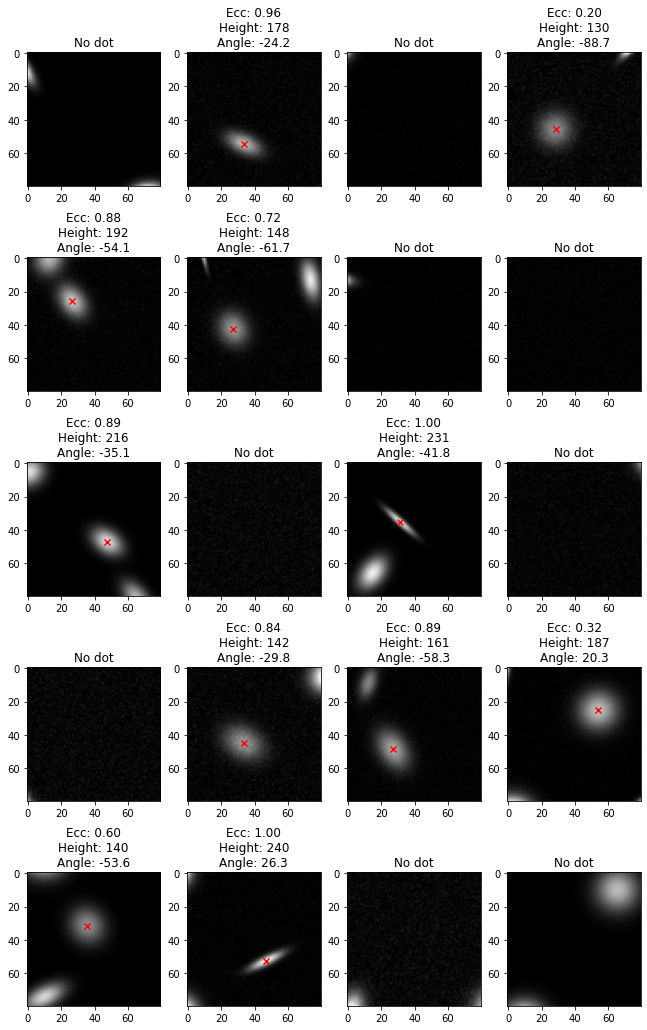

In [23]:
with h5py.File(filename, "r") as f:
    
    ii = 0
    Nrows=6
    plt.figure( figsize=(11,int(3.7*Nrows)) )
    hh=1
    
    for jj in range(5):
        
        for kk in range(4):
            I = f["x"][ii,...]     
            y = f["y"][ii,...]
            ii+=1

            plt.subplot(Nrows,4,hh)
            hh+=1
            plt.imshow(I, vmin=0, vmax=255, cmap="gray")

            if y[0]>0.5:
                mu_delta = y[1:3]
                mu = np.array([ WIN_SIZE//2,WIN_SIZE//2] ) + mu_delta*(WIN_SIZE/2)

                ecc = y[3]
                peak = y[4]                
                angle = np.arctan2(y[6],y[5])*0.5

                plt.scatter( mu[0], mu[1], marker="x",c="r" )
                plt.title("Ecc: %1.2f\nHeight: %d\nAngle: %3.1f"%(ecc,peak, angle*180.0/np.pi) )
            else:
                plt.title("No dot")
                
    plt.savefig("dataset_example.pdf")